### Image Segmentation using GluonCV

We'll walk through the process of using a pre-trained model for Image Segmentation using GluonCV. 

#### 1) Import
We'll need to import MXNet, GluonCV and Pyplot.

In [1]:
import mxnet as mx
import gluoncv as gcv
import matplotlib.pyplot as plt

#### 2) Download the Test Image
We will use the following image for Image Segmentation. 
![dog](https://raw.githubusercontent.com/zhreshold/mxnet-ssd/master/data/demo/dog.jpg)

The image have a few obvious objects. In the foreground, we have a dog that's just in front of a bike. And in the background, we have a tree and a car. We'd like a model to segment these images. So let's download this image from the url.

In [2]:
image_url = 'https://raw.githubusercontent.com/zhreshold/mxnet-ssd/master/data/demo/dog.jpg'
image_path = 'dog.jpg'
gcv.utils.download(url=image_url, path=image_path)

'dog.jpg'

#### 3) Load the Image

So let's load the image using imread(). 

data type:  <class 'numpy.uint8'>
shape:  (576, 768, 3)
type:  <class 'mxnet.ndarray.ndarray.NDArray'>


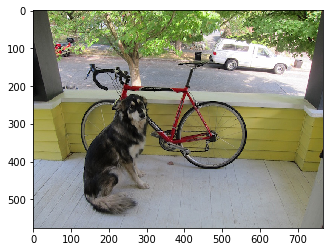

In [3]:
image = mx.image.imread(image_path)
print('data type: ', image.dtype)
print('shape: ', image.shape)
print('type: ', type(image))
plt.imshow(image.asnumpy())
plt.show()

#### 4) Transform the Image

When it comes to transforming the image, there are a few differences with semantic segmentation. We need to create our own custom transform from scratch as there are no preset transforms for the data set or the model that we are planning to use. 

With mxnet.gluon, it's easy to do. We can compose multiple transforms into a single transform function called *transform_fn*. 

We using two transforms here, ToTensor and normalize, and they're applied one after another. 

Using ToTensor, the data layer of the image will be converted from HWC to CHW. 

The datatype will be converted from an eight bit integer to a 32-bit float. 

The method called normalize will normalize the values of the image using the ImageNet one case statistics. 

In [4]:
from mxnet.gluon.data.vision import transforms

transform_fn = transforms.Compose([transforms.ToTensor(), 
                                   transforms.Normalize([.485, .456, .406],[.229, .224, .225])
                                  ])

We can apply the transform function just like a regular function. 

Calling *transform_fn* with the image, our output has all of the expected properties.

In [5]:
image = transform_fn(image)

print('data type: ', image.dtype)
print('shape: ', image.shape)
print('minimum value: ', image.min().asscalar())
print('maximum value: ', image.max().asscalar())

data type:  <class 'numpy.float32'>
shape:  (3, 576, 768)
minimum value:  -2.117904
maximum value:  2.64


#### 5) Batch Image

One final step is to create a batch from a single image. 

We just need to add an extra dimension to the beginning of our image using the *expand_dims* method. 

In [6]:
image = image.expand_dims(0)

print(image.shape)

(1, 3, 576, 768)


Zero indicates that the new dimension will be added as the first dimension. 

You can see the effect of this by looking at the new image shape. You should notice the size of the first dimension is one. 

Then we have three channels and a heightened width of 567 and 768. 

#### 6) Load Pretrained Model
We can use the *get_model* function to load our pretrained model from the gluoncv.model_zoo. **Don't forget to set the pretrained argument to true.**

We'll use the FCN network with a resonant 50 backbone that's been trained on the ADE20K data set. 

In [10]:
network = gcv.model_zoo.get_model('fcn_resnet50_ade', pretrained=True)

#### 7) Prediction
You can call network just like a function once again. You have network in image and a prediction will be returned. Output is a single mxnet.ndarray this time, unlike for the object detection when we have a tuple of three ndarrays. Our output is a batch of predictions.

In [12]:
output = network.demo(image)
print(output.shape)

(1, 150, 576, 768)


/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/gluoncv/model_zoo/segbase.py:102: UserWarning: demo method will be deprecated in favor of predict.
  warnings.warn('demo method will be deprecated in favor of predict.')


Since we only had one input image, let's just slice off the batch dimension and take the first and only prediction. 

In [13]:
output = output[0]
print(output.shape)

(150, 576, 768)


Now, we're left with the prediction that has a shape of 150 by 576 by 768, and a data layout of CHW. 

We have 150 channels because there are 150 classes in the ADE20K data set that was used for pretraining this model.

You should recognize the last two numbers because they correspond to our images height and width. 

All of the values in this array are logits, so we still need to process the outputs to obtain probabilities. We don't want to apply the softmax to all of these values at once though. We want to do this independently for all pixels so that each pixel has a predicted probability distribution across classes.

We can jump straight into an example of processing a single pixel, and then see how this can be done for all pixels at once.

#### 8) Clooser Look at Pixel Slice
With our coordinate origin at the top left of the image, let's choose a pixel with the position of 300 along the vertical axis and 500 along the horizontal axis. 

Since the output was in CHW format, we can slice using the colon notation at the start to keep all of the output channels for this particular pixel. 

As mentioned previously, our outputs are currently logits. We can use the softmax function to convert the logits to probabilities, and after rounding the results for convenience we can see the probability distribution across classes for this particular pixel.


In [14]:
px_height, px_width = 300, 500
px_logit = output[:, px_height, px_width]

px_prob = mx.nd.softmax(px_logit)
px_rounded_prob = mx.nd.round(px_prob*100)/100

print(px_rounded_prob)


[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.96 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
<NDArray 150 @cpu(0)>


One of the highest probabilities is towards the end with a probability of 96 percent. 

Using the argmax function we can find the most likely class for this pixel. 

After converting from an mxnet float to a Python integer, we can say that the class 127 is the most likely. 

In [15]:
class_idx = mx.nd.argmax(px_logit, axis = 0)
class_idx = class_idx[0].astype('int').asscalar()
print(class_idx)

127


But what is this class? We need a lookup table from class indexes to class labels. 

You can usually find a lookup table on the classes property of a pretrained network, but it's also possible to use the data set directly for this. 

We import the ADE20K segmentation date set class and use the classes property to find the corresponding class label for our pixel prediction. 

We find that the most likely class for the selected pixel is bike. We know our image contains a bike near the center. 

So this seems like a reasonable prediction. 

In [16]:
from gluoncv.data.ade20k.segmentation import ADE20KSegmentation

class_label = ADE20KSegmentation.CLASSES[class_idx]
print(class_label)

bicycle, bike, wheel, cycle


We can perform the same analysis for all pixels at once with a minor change in how we use softmax.

We've previously been applying softmax across all values. But by specifying axis equals 0, we can apply softmax independently for all pixels. 

Axis zero corresponds to the channel dimension which are the classes. 

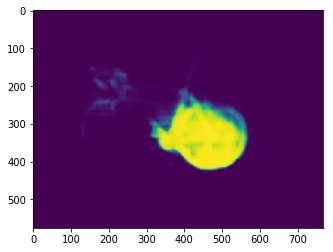

In [19]:
output_prob = mx.nd.softmax(output, axis=0)
ouput_heatmap = output_prob[127]
plt.imshow(ouput_heatmap.asnumpy())

Here the output is a probability distribution across classes for every pixel. 

Although we can't easily visualize an image with a 150 channels, we can take a slice across channels this time. 

Sticking with our predicted classroom before, we can slice the 127th channel and obtain an image with the probabilities of each pixel being a bike. 

We have an obvious cluster of pixels with a very high probability of being a bike. We can see the outline of the bike wheel and the bike frame.

#### 9) Visualize Most Likely Class

We could do the same thing for each class, but with 150 classes, this can be a little overwhelming. 

A much more useful visualization is to take the most likely class for every pixel. 

We can use argmax just like before. Our prediction is now a single-channel array with the same height and width, but where all pixel values are class indexes. 

In [22]:
prediction = mx.nd.argmax(output, 0).asnumpy()
print(prediction.shape)
print(prediction)

(576, 768)
[[0. 0. 0. ... 4. 4. 4.]
 [0. 0. 0. ... 4. 4. 4.]
 [0. 0. 0. ... 4. 4. 4.]
 ...
 [3. 3. 3. ... 0. 0. 0.]
 [3. 3. 3. ... 0. 0. 0.]
 [3. 3. 3. ... 0. 0. 0.]]


We could visualize this array directly, but we'd be limited to gray scale colors, and the contrast between classes could be limited. 

We can instead map each class to a different color in the RGB space, and there are preset mappings for the VOC and ADE20K data sets. 

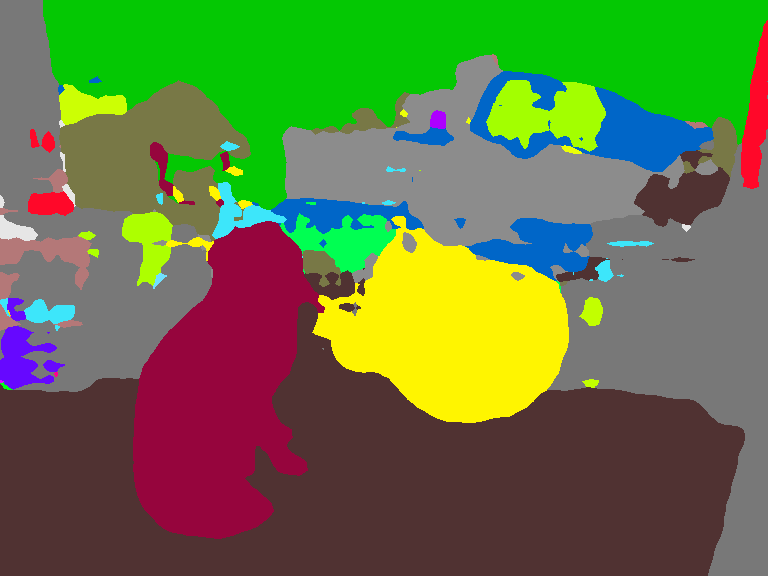

In [24]:
from gluoncv.utils.viz import get_color_pallete

prediction_image = get_color_pallete(prediction, 'ade20k')
prediction_image

Using this mapping, we can clearly see the different segments from our original image. 

Yellow is used to show regions where the classification is bike for example. 

In conclusion, we started by pre-processing the input image. We then loaded a segmentation model from the model_zoo and used it to generate a prediction. Finally, we interpreted the network outputs and visualize the segments.